In [234]:
#importy
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt


In [235]:
#stale
L = 2

In [236]:
#dziedzina
geometry1 = dde.geometry.Hypercube(xmin=[-L/2, -L/2, 0.99, 0.99], xmax=[L/2, L/2, 1.01, 1.01])
geometry2 = dde.geometry.Hypercube(xmin=[-L/2, -L/2, 1.99, 1.99], xmax=[L/2, L/2, 2.01, 2.01])

geometry = dde.geometry.CSGUnion(geometry1, geometry2)

geometry1 = dde.geometry.Hypercube(xmin=[-L/2, -L/2, 0.99, 1.99], xmax=[L/2, L/2, 1.01, 2.01])
geometry2 = dde.geometry.Hypercube(xmin=[-L/2, -L/2, 1.99, 0.99], xmax=[L/2, L/2, 2.01, 1.01])

geometry = dde.geometry.CSGUnion(geometry, geometry1)
geometry = dde.geometry.CSGUnion(geometry, geometry2)






In [237]:
#funkcja
def pde(x, u):
    du_xx = dde.grad.hessian(u, x, i=0, j=0)
    du_yy = dde.grad.hessian(u, x, i=1, j=1)
    n1 = x[:, 2:3]
    n2 = x[:, 3:4]
    return (du_xx + du_yy)/2 + (n1**2 + n2**2) * np.pi**2 * u / (2 * L**2)

def solution(x):
    xi = x[:, 0:1]
    yi = x[:, 1:2]
    n1 = x[:, 2:3]
    n2 = x[:, 3:4]
    
    return 2/L * np.sin(n1*np.pi*(xi+L/2) / L) * np.sin(n2*np.pi*(yi+L/2) / L)



In [238]:
#warunki brzegowe

def boundaryFunction(x, on_boundary):
    if dde.utils.isclose(x[0], 0) or dde.utils.isclose(x[1], 0):
        return True
    if on_boundary and (dde.utils.isclose(abs(x[0]), L/2) or dde.utils.isclose(abs(x[1]), L/2)):
        return True
    return False



boundary_conditions = dde.icbc.DirichletBC(geometry, 
                                            lambda x: solution(x), 
                                            boundaryFunction
                                            )


In [239]:
#dane
data = dde.data.PDE(geometry, 
                    pde, 
                    boundary_conditions, 
                    num_domain=3000,
                    num_boundary=5000,
                    num_test=1500
                    )

In [240]:
#siec
net = dde.nn.FNN([4]+[30]*2+[1],
                "tanh",
                "Glorot normal"
                )



In [241]:
#model
model = dde.Model(data, net)

model.compile("adam", lr=0.001)

Compiling model...
Building feed-forward neural network...
'build' took 0.061964 s

'compile' took 0.865857 s



Training model...

Step      Train loss              Test loss               Test metric
0         [7.42e+00, 1.78e-01]    [7.63e+00, 1.78e-01]    []  
500       [7.27e-04, 4.30e-04]    [6.91e-04, 4.30e-04]    []  
1000      [3.58e-04, 4.13e-04]    [3.45e-04, 4.13e-04]    []  
1500      [2.13e-04, 4.03e-04]    [1.88e-04, 4.03e-04]    []  
2000      [1.23e-04, 3.96e-04]    [1.03e-04, 3.96e-04]    []  
2500      [7.20e-05, 3.93e-04]    [6.06e-05, 3.93e-04]    []  
3000      [4.32e-05, 3.92e-04]    [3.89e-05, 3.92e-04]    []  
3500      [2.77e-05, 3.91e-04]    [2.68e-05, 3.91e-04]    []  
4000      [1.96e-05, 3.90e-04]    [1.97e-05, 3.90e-04]    []  
4500      [1.53e-05, 3.89e-04]    [1.53e-05, 3.89e-04]    []  
5000      [1.26e-05, 3.89e-04]    [1.24e-05, 3.89e-04]    []  

Best model at step 5000:
  train loss: 4.02e-04
  test loss: 4.02e-04
  test metric: []

'train' took 269.410671 s



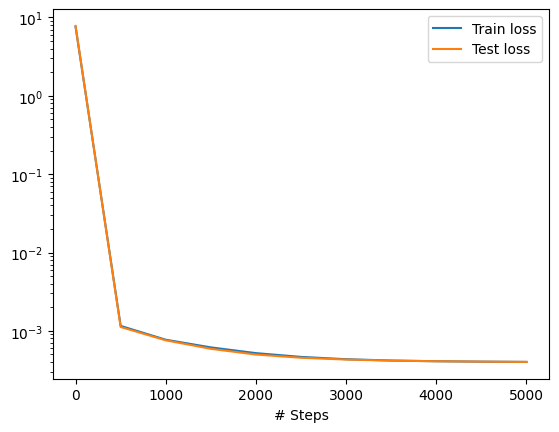

In [242]:
#trenowanie
loss_history, train_state = model.train(iterations = 5000, display_every=500)
dde.saveplot(loss_history, train_state, issave=False, isplot=True)


In [243]:
#testowanie
xData = np.linspace(-L/2, L/2, 1000)
yData = np.linspace(-L/2, L/2, 1000)
n1 = np.array([1 for i in range(1000)])
n2 = np.array([1 for i in range(1000)])

X = np.vstack((np.ravel(xData), np.ravel(yData), np.ravel(n1), np.ravel(n2))).T


y_pred = model.predict(X)

y_true = solution(X)




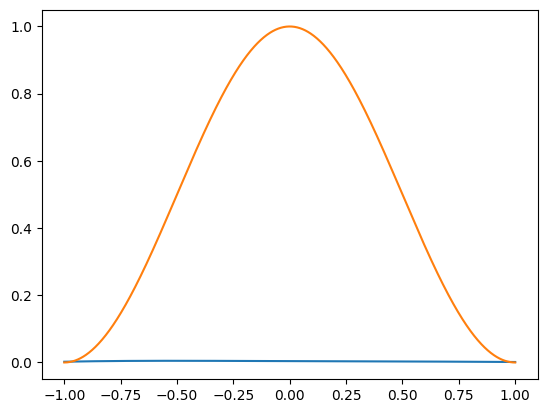

In [244]:
#wykresy
plt.plot(X[:, 0:1], y_pred, label="rozwiązanie sieci")
plt.plot(X[:, 0:1], y_true, label="rozwiązanie analityczne")
# plt.legend()
plt.show()




/tmp/ipykernel_4991/662956923.py:2: RuntimeWarning: divide by zero encountered in divide
  errors = abs(y_pred - y_true) / y_true


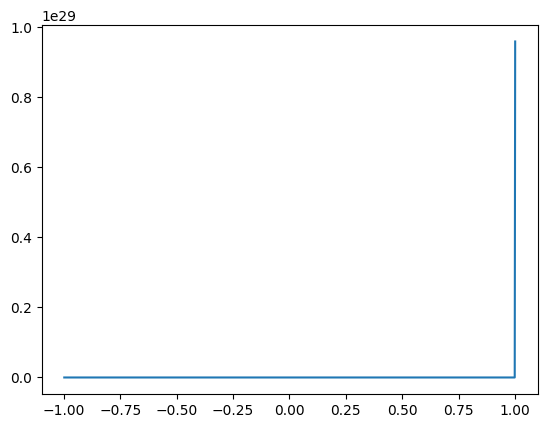

In [245]:
#bledy
errors = abs(y_pred - y_true) / y_true
plt.plot(X[:, 0:1], errors)
plt.show()